#Procesamiento de datos del Visound
Esta rutina procesa y visualiza los datos que se generan con el programa visound.
La app va subiendo los datos a un servidor. Este servidor corre en una virtual machine en la compu de casa sobre un ubuntu server en el que instale un json-server. 
Esta rutina descarga los datos del servidor en su ultima version y los procesa para hacer una visualizacion de la actividad de los usuarios en forma grafica (un timeline de la actividad)

In [1]:
%matplotlib inline
from IPython import embed
#from Scripts import *
from graficos import *
from LoadDataFromFile import *
from DownloadFile import *

# Recoleccion de datos

Bajamos la ultima version del archivo de internet y nos fijamos de guardar la version anterior con una marca temporal

In [2]:
DownloadFile ()

In [2]:
data = LoadDataFromFile()

# Con los datos ya cargados graficamos los resultados

La idea de esta seccion es hacer un analisis visual de los datos. Para eso vamos a armar un timeline donde vamos a mostrar con dibujos (lines, rectangulos, etc) lo que va pasando en el juego en funcion de diferentes criterios. Para un usuario cuando jugo, en usa sesion que paso, etc.

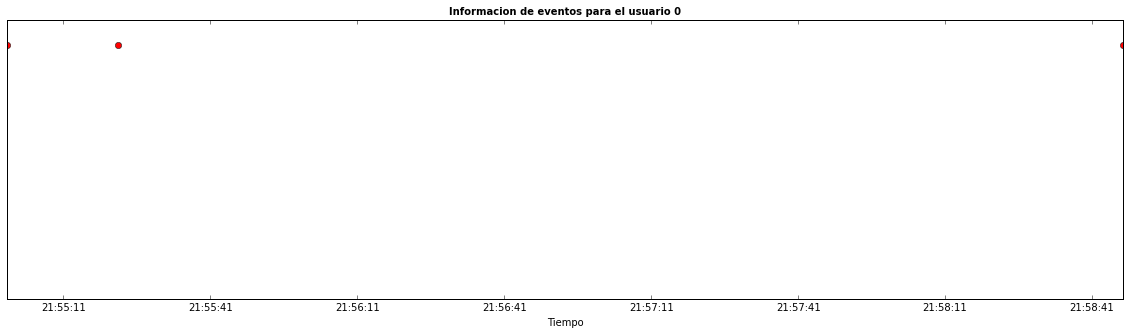

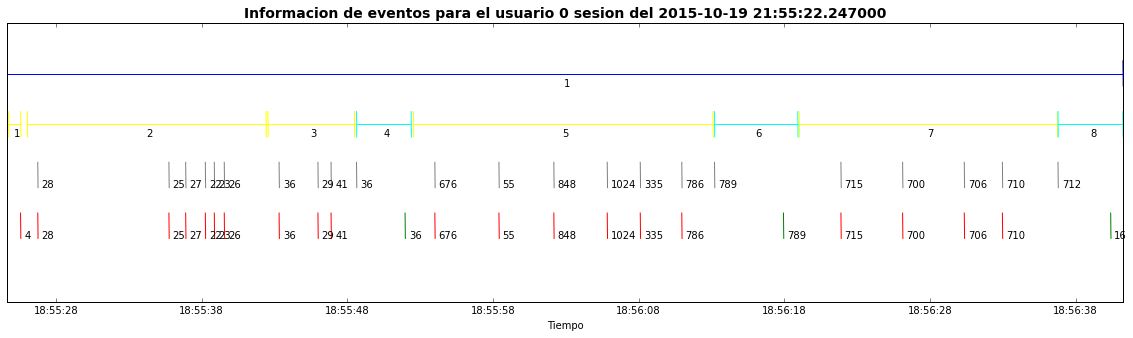

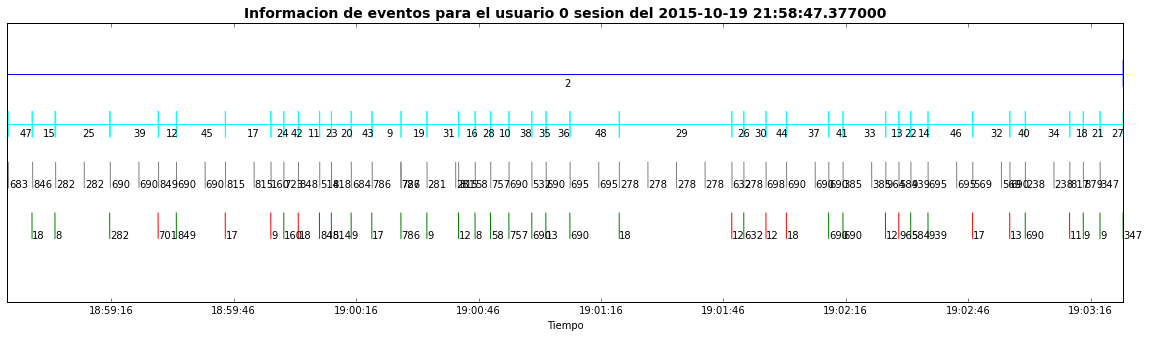

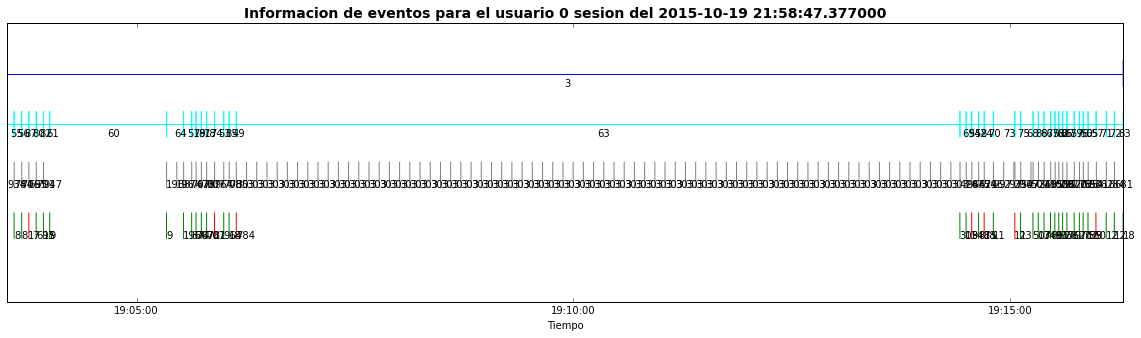

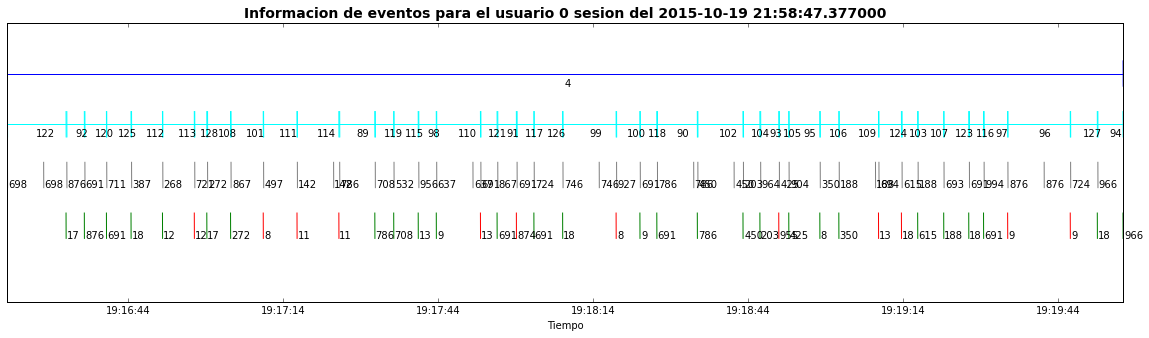

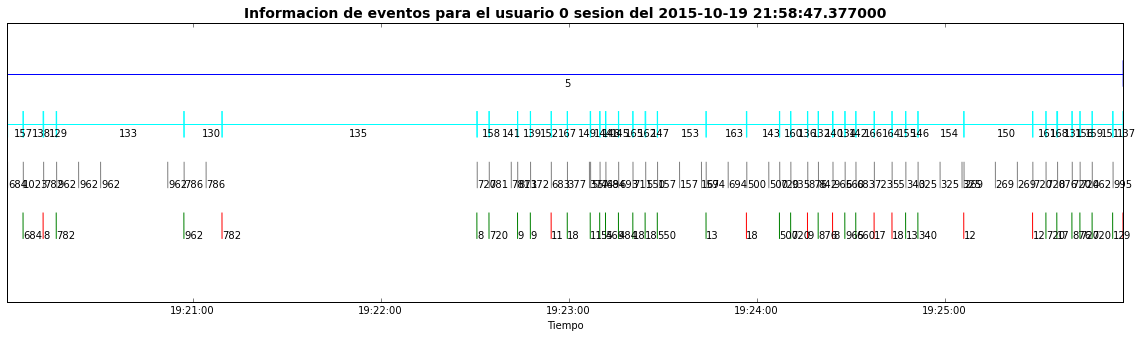

In [4]:
graficarTimeline (data)

# Cosas de estadistica

En esta seccion se va a hacer un procesamiento estidistico de los datos para evaluar los resultados en funcion de diferentes parametros.


Se analizara las estadisticas del usuario 0:
Cantidad de veces que se logueo el usuario: 3
Fechas:
2015-10-19 18:54:59.523999
2015-10-19 18:55:22.246999
2015-10-19 18:58:47.377000

Se analizara la sesion del 2015-10-19 18:54:59.523999
Numero de niveles jugados en esta sesion: 0

Se analizara la sesion del 2015-10-19 18:55:22.246999
Numero de niveles jugados en esta sesion: 1

Detalles del nivel: 1
Titulo del nivel: Tutorial
Horario de juego: 2015-10-19 18:55:24.663000
Duracion del nivel: 1.2764 minutos

Detalle de los trials del nivel 1:
[2.999, 3.001]
[0, 0.25]


Se analizara la sesion del 2015-10-19 18:58:47.377000
Numero de niveles jugados en esta sesion: 4

Detalles del nivel: 2
Titulo del nivel: Test
Horario de juego: 2015-10-19 18:58:50.476999
Duracion del nivel: 4.5582 minutos

Detalle de los trials del nivel 2:
[27.999, 28.001]
[0, 0.070000000000000007]


Detalles del nivel: 3
Titulo del nivel: Test
Horario de juego: 2015-10-19 19:03:31.183000
Duracion del nivel: 12.771 minutos

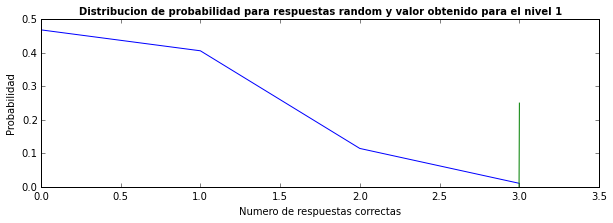

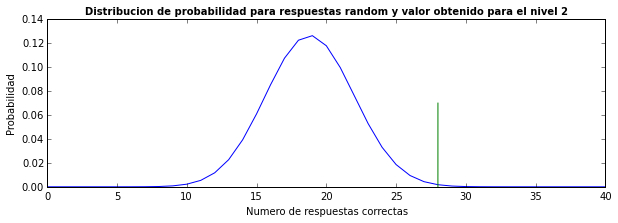

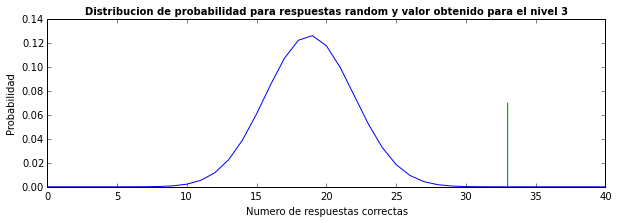

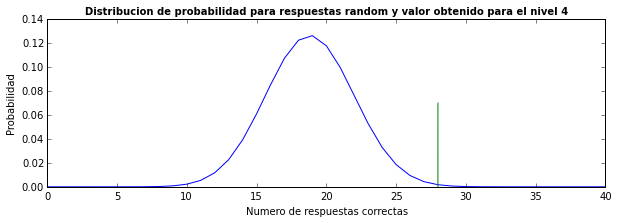

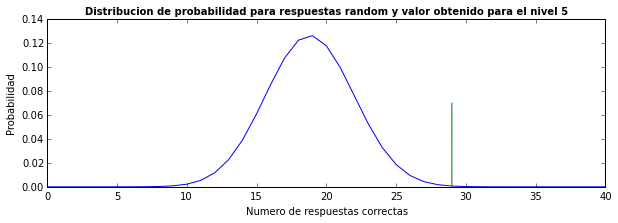

In [9]:
for index, usuario in data['usuarios'].iterrows():
    analizarUsuario(usuario,data)

In [20]:
touchs.columns

        
        
        

Index(['categorias', 'idResourceTouched', 'isTrue', 'levelInstance',
       'numberOfSoundLoops', 'sessionInstance', 'soundIdSecuenceInTrial',
       'soundInstance', 'soundRunning', 'timeLastStartSound',
       'timeLastStopSound', 'timeSinceTrialStarts', 'tipoDeTrial',
       'touchInstance', 'trialId', 'trialInstance'],
      dtype='object')

In [8]:
def distribucionDeProbabilidadRandom (histograma):
    
    import math
    
    distribuciones = [0] * len(histograma)
    # Primer calculamos la distribucion de probabilidad para cada subset de trials con identicas opciones de respuesta
    for i in range(len(histograma)):
        N = i+1 # Representa el numero de opciones posibles a elegir
        m = histograma[i] # Representa el numero de trials que se contestan en el subset
        subset_N = [0] * (m+1) # Sumamos el 1 porque si hay cero elementos igual hay una opcion, las opciones son el cerrado [0,numero de trials]
        p = 1/N # es la probabilidad de acertar entre la cantidad de opciones presentadas (que es i+1)
        if m==0:
            distribuciones[i] = [1]
        else:
            for j in range(m+1): # j representa la cantidad de opciones correctas
                # Calculamos la probabilidad de obtener una cantidad de respuestas correctas j, cuando cada trial tiene N opciones
                Pj = math.pow(p,j)*math.pow(1-p,m-j)*math.factorial(m)/(math.factorial(j)*math.factorial(m-j))
                subset_N[j] = Pj
            distribuciones[i] = subset_N
    # Aqui ya esta la distribucion de cada subset. ahora hay que calcular la distribucion global, para eso hay que combinar las dritribciones
    
    # La idea es que si tenemos dos distribuciones N1 y N2 cada uno con J y J' elementos (donde J y J' es el numero de trials maximo que hay con N1 y N2 opciones)
    # y j1 representa la probabilidad de responder j1 veces bien en los trials de N1 opciones y j2 representar la probabilidad de responder j2 veces bien
    # en los trials de N2 opciones, 
    # entonces la suma de todos los productos cuyos indices j1 +j2 de j3 es la probabilidad de responde j3 veces bien entre los trials de N1 y N2 opciones 
    combinado = [1] # Inicialmente hay probabilidad 1 de tener 0 bien
    for N in range(len(distribuciones)):
        combinadoNew = [0] * (sum(histograma)+1) # Armo una combinacion que este vacia
        for i_1 in range(len(combinado)):
            if combinado[i_1] != 0: # Esto tiene dos razones, una es evitar cuentas innecesarias. La otra mas importante es evitar que aplique el contador hasta el final y que la suma de los dos contadores de mas que el numero de trials maximos posible, lo que genera un error
                for i_2 in range(len(distribuciones[N])):
                    combinadoNew[i_1+i_2] = combinadoNew[i_1+i_2] + combinado[i_1]*distribuciones[N][i_2] #Acumulo todos las combinaciones
        combinado = combinadoNew
    
    return combinado



def analizarSesion (sesion, data):
    
    import matplotlib.pyplot as plt
    
    #Carga los datos
    levels=data['levels']
    trials=data['trials']
    touchs=data['touchs']
    
    print ('Se analizara la sesion del '+ str(fechaLocal(sesion['id'])))
    levelsSesion = levels[levels['sessionId']==sesion['id']]

    print ('Numero de niveles jugados en esta sesion: '+str(len(levelsSesion.index)))
    print ('')
    
    for index, level in levelsSesion.iterrows():
        print ('Detalles del nivel: '+str(level['levelId']))
        print ('Titulo del nivel: ' + level['levelTitle'])
        print ('Horario de juego: ' + str(fechaLocal(level['levelInstance'])))
        print ('Duracion del nivel: ' + str((level['timeExit']-level['timeStarts'])/1000 * 1/60)[:-12] + ' minutos')
        
        if not level['levelCompleted']:
            print ('Nivel incompleto')
        
        print ('')
        print ('Detalle de los trials del nivel '+str(level['levelId'])+':')
        trialsLevel = trials[trials['levelInstance']==level['levelInstance']]
        trialsLevelTest = trialsLevel[trialsLevel['tipoDeTrial']=='TEST']
        histograma = makeHistogramaTrials(trialsLevelTest)
        # print ('Histograma de numero de opciones a responder para el nivel: ' + str(histograma))
        distribucion = distribucionDeProbabilidadRandom(histograma)
        # Hacemos un plot con los datos y el resultado
        fig = plt.figure(figsize=(10,3))
        ax = fig.add_subplot(111)
        ax.set_title('Distribucion de probabilidad para respuestas random y valor obtenido para el nivel ' + str(level['levelId']), fontsize=10, fontweight='bold')
        ax.set_xlabel('Numero de respuestas correctas')
        ax.set_ylabel('Probabilidad')
        x = range(len(distribucion))
        y = distribucion
        ax.plot(x,y)
        # Ahora agregamos la marca del numero obtenido, para eso primero hay que calcularlo
        touchsLevel = touchs[touchs['levelInstance']==level['levelInstance']]
        aciertos = 0
        for index, touch in touchsLevel.iterrows():
            if touch['tipoDeTrial'] == 'TEST':
                if touch['isTrue'] == True:
                    aciertos = aciertos + 1
        x=[aciertos-0.001,aciertos+0.001]        
        y=[0,ax.get_ylim()[1]/2]
        color = 'green'
        ax.plot(x,y,color)
        print ('')
        print ('')

def analizarUsuario (usuario, data):
    #Carga los datos necesarios
    sessions = data['sessions']
    
    print ('Se analizara las estadisticas del usuario '+ str(usuario['Alias'])+':')
    sesionesUsuario = sessions[sessions['userID']==usuario['usuarios']]
    
    print ('Cantidad de veces que se logueo el usuario: '+str(len(sesionesUsuario.index)))
    print ('Fechas:')
    
    for fecha in sesionesUsuario['id']:
        print (str(fechaLocal(fecha)))
    
    print ('')
    
    for index, session in sesionesUsuario.iterrows():
        analizarSesion(session,data)

def fechaLocal (millisec):
    import datetime
    
    return datetime.datetime.fromtimestamp(millisec/1000)

def makeHistogramaTrials (trials):
    
    #
    # Esta rutina encuentra un histograma de frecuencia de cantidad de opciones para elegir respuesta.
    # La idea es que con estos datos despues se puede calcular como es una distribucion de respuestas random y asi saber cual es la probabilidad de hipotesis nula
    # El histograma tiene que tener un largo igual al maximo de opciones posibles +1 porque el en casillero cero se guarda la cantidad con cero opciones
    # Esto no tiene mucho sentido conceptual aca pero si despues para las cuentas
    #
    
    histograma = []
    for index, trial in trials.iterrows():
        # REVISAR esto sirve para la version vieja de datos, en el futuro hay que cambiarlo para que busque en el json bien donde corresponde
        if len(trial['resourcesIdSort']) > len (histograma): 
            ext = [0] * (len(trial['resourcesIdSort'])-len (histograma))
            histograma.extend(ext)
        histograma[len(trial['resourcesIdSort'])-1] = histograma[len(trial['resourcesIdSort'])-1] + 1
    return histograma